In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from modules.dataset import *
from modules.network import *
from modules.embeddings import *
from torch import save, device, cuda
from torch.utils.data import DataLoader

In [2]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


# Dataset

## Loading and preprocessing

In [3]:
#%%Loading the dataset 
dataset = Mobydick('./data/mobydick.txt', min_len = 10)

with open('./data/clean_text', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    
len(dataset)

466

In [4]:
# Given a min_len>2, it is not necessary to delete the chapters titles
print(dataset[0])

['some', 'years', 'ago', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'i', 'thought', 'i', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']


Mean sentence length: 30.446351931330472
Max sentence length: 127
Min sentence length: 10


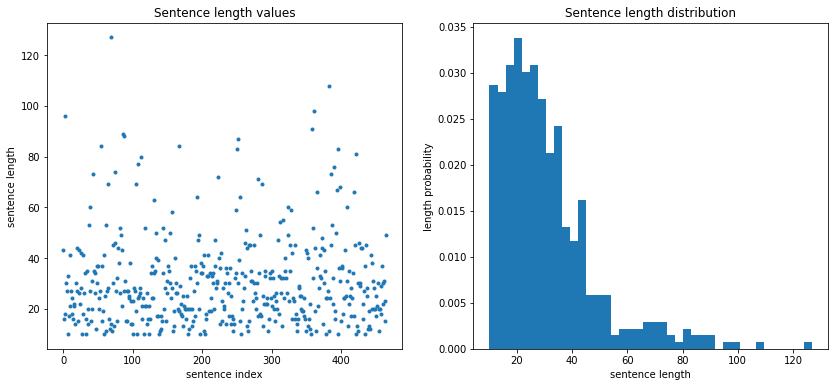

In [5]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

In [6]:
# Word visualization
print(len(dataset.words))

14188


## Word embeddings

In [7]:
# Define the embedding dimension
embedding_dim = 50

# Copy dataset words
words = set(dataset.words.copy())

In [8]:
# Load embeddings
with open('./data/embeddings', 'rb') as f:
    embeddings = pickle.load(f)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [9]:
# Define transformation 
dataset.transform = transforms.Compose([
    RandomCrop(8),
    WordToVector(words),
    ToTensor()
])

In [10]:
# Defined the transform, this call returns the word index (after random cropping)
dataset[0].shape

torch.Size([8])

# LSTM

In [11]:
##Parameters

# network
hidden_units = 2**6 # symmetric layers
layers_num = 2
dropout_prob = 0.4

# training
batch_size = 100
num_epochs = 10000

# optimizer
lr = 1e-2
wd = 1e-3

# save
out_dir = f'LSTM_{hidden_units}_{layers_num}_{dropout_prob}'

In [12]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = hidden_units,
              layers_num = layers_num,
              hidden_type = 'LSTM',
              trained_embeddings = vectors,
              dropout_prob = dropout_prob
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
# Define loss function
loss_fn = nn.MSELoss()
# loss_fn = nn.NLLLoss()

net.to(device)

Network(
  (rnn): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.4)
  (out): Linear(in_features=64, out_features=50, bias=True)
  (embed): Embedding(2998, 50)
)

In [14]:
# w2v = WordToVector(words)
# w2v.decoder

In [17]:
%%time

#%% Train network

# Define losses containers
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(num_epochs):
    print('##################################')
    print('## EPOCH %d' % (epoch + 1))
    print('##################################')
    
    # Set training mode
    net.train()
    # Define losses container for one epoch
    train_loss_log = []
    
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log.append(batch_loss)
        # print('\t Training loss (single batch):', batch_loss)
        
    print('\t Training loss (epoch - mean): ', np.mean(train_loss_log) )
    train_loss_epochs.append(np.mean(train_loss_log))
    
    # Set evaluation mode
    net.eval()
    with torch.no_grad():
        val_loss = net.test_batch(batch, loss_fn)
        print('\t Validation loss (epoch):', val_loss)
        val_loss_epochs.append(val_loss)
    
losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs }

# Save losses dictionary
# res_path = "./drive/My Drive/Colab Notebooks/results/losses"
# with open(res_path + "/" + out_dir, 'wb') as f:
#     pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)

##################################
## EPOCH 1
##################################
batch shape: torch.Size([100, 8])
out shape: torch.Size([100, 50])
embed target shape: torch.Size([100, 50])
batch shape: torch.Size([100, 8])
out shape: torch.Size([100, 50])
embed target shape: torch.Size([100, 50])
batch shape: torch.Size([100, 8])
out shape: torch.Size([100, 50])
embed target shape: torch.Size([100, 50])
batch shape: torch.Size([100, 8])
out shape: torch.Size([100, 50])
embed target shape: torch.Size([100, 50])
batch shape: torch.Size([19, 8])
out shape: torch.Size([19, 50])
embed target shape: torch.Size([19, 50])
	 Training loss (epoch - mean):  0.21135662794113158
	 Validation loss (epoch): 0.12447865307331085
##################################
## EPOCH 2
##################################
batch shape: torch.Size([100, 8])
out shape: torch.Size([100, 50])
embed target shape: torch.Size([100, 50])
batch shape: torch.Size([100, 8])
out shape: torch.Size([100, 50])
embed target shape: 